Load Julia packages (libraries) needed  for the snippets in chapter 0

In [1]:
using StatisticalRethinking
using CmdStan, StanMCMCChain
gr(size=(500,800))

Plots.GRBackend()

CmdStan uses a tmp directory to store the output of cmdstan

In [2]:
ProjDir = rel_path("..", "chapters", "04")
cd(ProjDir)

### snippet 4.7

In [3]:
howell1 = CSV.read(joinpath(dirname(Base.pathof(StatisticalRethinking)), "..", "data", "Howell1.csv"), delim=';')
df = convert(DataFrame, howell1);

Use only adults

In [4]:
df2 = filter(row -> row[:age] >= 18, df)
mean_weight = mean(df2[:weight])
df2[:weight] = convert(Vector{Float64}, df2[:weight]) .- mean_weight

352-element Array{Float64,1}:
   2.8351209801136577
  -8.50467901988634  
 -13.125647519886343 
   8.051428980113656 
  -3.7136135198863442
  18.00210348011366  
  -6.747010019886339 
  10.489485980113656 
 -10.120600519886345 
   9.497253480113656 
   ⋮                 
   2.8918199801136595
  -5.584680519886341 
  -3.9404095198863445
  -4.167205519886345 
   2.0413349801136604
 -10.744289519886344 
   7.172594480113659 
   9.07201098011366  
   7.54113798011366  

Define the Stan language model

In [5]:
weightsmodel = "
data {
 int < lower = 1 > N; // Sample size
 vector[N] height; // Predictor
 vector[N] weight; // Outcome
}

parameters {
 real alpha; // Intercept
 real beta; // Slope (regression coefficients)
 real < lower = 0 > sigma; // Error SD
}

model {
 height ~ normal(alpha + weight * beta , sigma);
}

generated quantities {
}
"

"\ndata {\n int < lower = 1 > N; // Sample size\n vector[N] height; // Predictor\n vector[N] weight; // Outcome\n}\n\nparameters {\n real alpha; // Intercept\n real beta; // Slope (regression coefficients)\n real < lower = 0 > sigma; // Error SD\n}\n\nmodel {\n height ~ normal(alpha + weight * beta , sigma);\n}\n\ngenerated quantities {\n}\n"

Define the Stanmodel and set the output format to :mcmcchain.

In [6]:
stanmodel = Stanmodel(name="weights", monitors = ["alpha", "beta", "sigma"],model=weightsmodel,
  output_format=:mcmcchain)
# Input data for cmdstan
heightsdata = [
  Dict("N" => length(df2[:height]), "height" => df2[:height], "weight" => df2[:weight])
]

=====> /Users/rob/.julia/dev/StatisticalRethinking/chapters/04


File /Users/rob/.julia/dev/StatisticalRethinking/chapters/04/tmp/weights.stan will be updated.



1-element Array{Dict{String,Any},1}:
 Dict("height"=>Union{Missing, Float64}[151.765, 139.7, 136.525, 156.845, 145.415, 163.83, 149.225, 168.91, 147.955, 165.1  …  156.21, 160.655, 146.05, 156.21, 152.4, 162.56, 142.875, 162.56, 156.21, 158.75],"weight"=>[2.83512, -8.50468, -13.1256, 8.05143, -3.71361, 18.0021, -6.74701, 10.4895, -10.1206, 9.49725  …  -0.963712, 2.89182, -5.58468, -3.94041, -4.16721, 2.04133, -10.7443, 7.17259, 9.07201, 7.54114],"N"=>352)

Sample using cmdstan

In [7]:
rc, chn, cnames = stan(stanmodel, heightsdata, ProjDir, diagnostics=false,
  CmdStanDir=CMDSTAN_HOME)
# Describe the draws
describe(chn)



--- Translating Stan model to C++ code ---
bin/stanc  /Users/rob/.julia/dev/StatisticalRethinking/chapters/04/tmp/weights.stan --o=/Users/rob/.julia/dev/StatisticalRethinking/chapters/04/tmp/weights.hpp
Model name=weights_model
Input file=/Users/rob/.julia/dev/StatisticalRethinking/chapters/04/tmp/weights.stan
Output file=/Users/rob/.julia/dev/StatisticalRethinking/chapters/04/tmp/weights.hpp

--- Linking C++ model ---
clang++ -Wall -I . -isystem stan/lib/stan_math/lib/eigen_3.3.3 -isystem stan/lib/stan_math/lib/boost_1.66.0 -isystem stan/lib/stan_math/lib/sundials_3.1.0/include -std=c++1y -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -DBOOST_PHOENIX_NO_VARIADIC_EXPRESSION -Wno-unused-function -Wno-uninitialized -I src -isystem stan/src -isystem stan/lib/stan_math/ -DFUSION_MAX_VECTOR_SIZE=12 -Wno-unused-local-typedefs -DEIGEN_NO_DEBUG -DNO_FPRINTF_OUTPUT -pipe   src/cmdstan/main.cpp  -O3 -o /Users/rob/.julia/dev/StatisticalRethinking/chapters/04/tmp/weights -

Compare with a previous result

In [8]:
clip_38s_example_output = "

Samples were drawn using hmc with nuts.
For each parameter, N_Eff is a crude measure of effective sample size,
and R_hat is the potential scale reduction factor on split chains (at
convergence, R_hat=1).

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Empirical Posterior Estimates:
          Mean         SD       Naive SE       MCSE     ESS
alpha 113.82267275 1.89871177 0.0300212691 0.053895503 1000
 beta   0.90629952 0.04155225 0.0006569987 0.001184630 1000
sigma   5.10334279 0.19755211 0.0031235731 0.004830464 1000

Quantiles:
          2.5%       25.0%       50.0%       75.0%       97.5%
alpha 110.1927000 112.4910000 113.7905000 115.1322500 117.5689750
 beta   0.8257932   0.8775302   0.9069425   0.9357115   0.9862574
sigma   4.7308260   4.9644050   5.0958800   5.2331875   5.5133417

"

"\n\nSamples were drawn using hmc with nuts.\nFor each parameter, N_Eff is a crude measure of effective sample size,\nand R_hat is the potential scale reduction factor on split chains (at\nconvergence, R_hat=1).\n\nIterations = 1:1000\nThinning interval = 1\nChains = 1,2,3,4\nSamples per chain = 1000\n\nEmpirical Posterior Estimates:\n          Mean         SD       Naive SE       MCSE     ESS\nalpha 113.82267275 1.89871177 0.0300212691 0.053895503 1000\n beta   0.90629952 0.04155225 0.0006569987 0.001184630 1000\nsigma   5.10334279 0.19755211 0.0031235731 0.004830464 1000\n\nQuantiles:\n          2.5%       25.0%       50.0%       75.0%       97.5%\nalpha 110.1927000 112.4910000 113.7905000 115.1322500 117.5689750\n beta   0.8257932   0.8775302   0.9069425   0.9357115   0.9862574\nsigma   4.7308260   4.9644050   5.0958800   5.2331875   5.5133417\n\n"

Plot the density of posterior draws

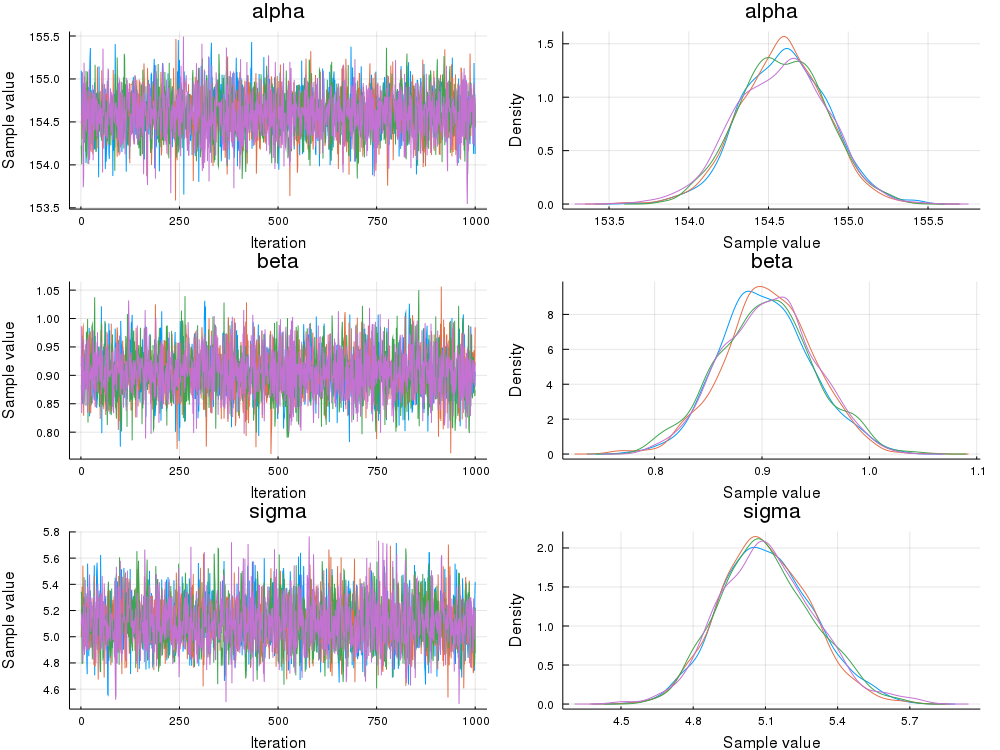

In [9]:
plot(chn)

Plot regression line using means and observations

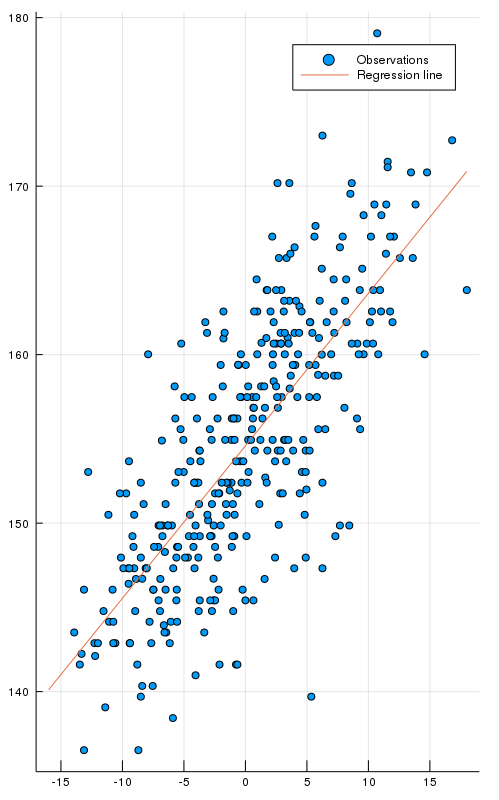

In [10]:
xi = -16.0:0.1:18.0
rws, vars, chns = size(chn[:, 1, :])
alpha_vals = convert(Vector{Float64}, reshape(chn.value[:, 1, :], (rws*chns)))
beta_vals = convert(Vector{Float64}, reshape(chn.value[:, 2, :], (rws*chns)))
yi = mean(alpha_vals) .+ mean(beta_vals)*xi

scatter(df2[:weight], df2[:height], lab="Observations")
plot!(xi, yi, lab="Regression line")

End of clip_38.0s.jl

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*